# Decision Trees and Random Forests

In this section of the project, we are going to continue to use the 2022 baseball season to predict wOBA values for balls in play. As a reminder, wOBA is an on-base percentage that accounts for how a player reached base with each event corresponding to a different wOBA value. Home runs have the highest wOBA value and an out has the lowest wOBA value. In order to predict wOBA values, launch angle and launch velocity will be the two variables examined.

In the last section, a K-nearest neighbor model was used to predict wOBA values and in this section, a Decision Tree and a Random Forest will be built to predict wOBA values. Once the models are built, they will be assessed and compared to the K-nearest neighbor model to determine which model is the best at predicting wOBA values. 

## Data Collection
To begin, the 2022 baseball season will be imported below. Once, the data is loaded, we print the column names out in order to determine our primary key. We will use a primary key later in the project which will allow us to join the main data table to our model. The columns that will be used to create the primary key are game_pk, at_bat_number, and pitch_number because they create a unique event when combined. 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pybaseball import statcast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import log_loss
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [2]:
stat_df = statcast(start_dt="2022-04-07", end_dt="2022-10-02")

This is a large query, it may take a moment to complete


 32%|█████████████████████████▊                                                       | 57/179 [00:28<01:51,  1.09it/s]C:\Users\AGaev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 32%|██████████████████████████▏                                                      | 58/179 [00:32<03:15,  1.62s/it]C:\Users\AGaev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch e

In [3]:
#To create a unique key
stat_df["primary_key"] = [str(x) + "_" + str(y) + "_" + str(z) for x, y, z in zip(stat_df["game_pk"], stat_df["at_bat_number"], stat_df["pitch_number"])]
stat_df[["primary_key","game_pk", "at_bat_number", "pitch_number"]]

,primary_key,game_pk,at_bat_number,pitch_number
2675,663419_78_6,663419,78,6
2855,663419_78_5,663419,78,5
2912,663419_78_4,663419,78,4
3128,663419_78_3,663419,78,3
3143,663419_78_2,663419,78,2
...,...,...,...,...
1718,661042_1_5,661042,1,5
1813,661042_1_4,661042,1,4
1887,661042_1_3,661042,1,3
1953,661042_1_2,661042,1,2


In [4]:
#Exit Velocity and Launch Angle
bip_df = stat_df[(pd.notnull(stat_df["bb_type"]))]
bip_df = bip_df.dropna(how="any", subset=["launch_speed", "launch_angle"])
list(set(bip_df["description"]))

['hit_into_play']

In [5]:
bip_df["ev_round"] = [round(ev) for ev in bip_df["launch_speed"]]
bip_df["la_round"] = [round(la) for la in bip_df["launch_angle"]]

### Visualize the Data
Below is a scatter plot of exit velocity and launch angle with wOBA values displayed in a coolwarm color scale. Red indicates a high wOBA value and blue is a low wOBA value. In the graph, the high wOBA values which are likely homeruns occur when the exit velocity is between ~100-120mph and a launch angle of ~20-50 degrees. 

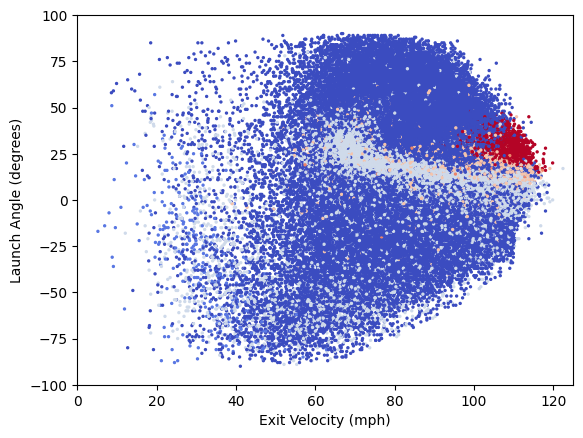

In [6]:
#Plot of the Data with wOBA values on a coolwarm color scale
fig, ax = plt.subplots()
plt.scatter(x=bip_df["launch_speed"], y=bip_df["launch_angle"], c=bip_df["woba_value"], s=2, cmap="coolwarm")
ax.set_xlim(0,125)
ax.set_ylim(-100,100)
ax.set_xlabel("Exit Velocity (mph)")
ax.set_ylabel("Launch Angle (degrees)")
plt.show()

A new table is created that includes only the necessary columns for this model. The columns that will be used are launch_speed, launch_angle, events, and primary_key. 

In [7]:
bip_df.isnull().values.any()

# Identify rows with NaN values
rows_with_nan = bip_df[bip_df.isnull().any(axis=1)]
 
#View the rows with NaN values
print(rows_with_nan)

#New Data table that includes Launch Speed, Launch Angle, and Events
#Make sure to add the columns needed for the primary key to the below code
ev_la_df = bip_df[["launch_speed", "launch_angle", "events","primary_key"]]

ev_la_df

     pitch_type  game_date  release_speed  release_pos_x  release_pos_z  \
3428         CU 2022-10-02           78.4           1.95           5.71   
4124         CH 2022-10-02           78.8           1.86            5.8   
2426         FF 2022-10-02           96.9          -2.12           5.78   
3768         FF 2022-10-02           98.5          -2.23           5.78   
1380         SI 2022-10-02           92.9           1.98           5.41   
...         ...        ...            ...            ...            ...   
1479         SI 2022-04-07           92.9           0.96           5.98   
1972         SI 2022-04-07           94.2           0.84           6.14   
1001         FF 2022-04-07           98.0           -2.0           5.95   
1345         FF 2022-04-07           97.7          -1.83           5.94   
1676         FF 2022-04-07           99.0          -2.01            5.9   

          player_name  batter  pitcher                     events  \
3428   Zastryzny, Rob  608369 

,launch_speed,launch_angle,events,primary_key
3428,54.2,37,field_out,663419_77_5
4124,95.1,25,field_out,663419_76_3
2426,100.5,0,grounded_into_double_play,663419_75_5
3768,88.6,39,field_out,663419_73_6
1380,97.1,4,single,663419_67_4
...,...,...,...,...
1479,80.2,-26,grounded_into_double_play,661042_8_4
1972,88.7,-53,field_out,661042_6_1
1001,81.5,64,field_out,661042_5_2
1345,80.7,-34,force_out,661042_3_5


## Model Build

Just like we did in the K-nearest neighbors model, in this section, each event is indexed from 0 to 5. For example, an out is 0 and a single is 1. Then the data is split into a training and test set with 75% of the data in the training set and 25% in the test set. Splitting the data into a training and test set is important because it allows us to assess how well the model performs on unseen data in the test set. 

In [10]:
#Categorize the events: Out, Single, Double, Triple, and Homerun
ev_la_df = ev_la_df[ev_la_df["events"].isin(["field_out", "single", "double", "triple", "home_run"])]
ev_la_df["events_encoded"] = [0 if x == "field_out" 
                                  else 1 if x == "single" 
                                  else 2 if x == "double" 
                                  else 3 if x == "triple" 
                                  else 4 if x == "home_run" 
                                  else 5 for x in ev_la_df["events"]]


# Split the data into features (X) and target (y)
X = ev_la_df.drop("events_encoded", axis=1)
Y = ev_la_df["events_encoded"]

# Split the data into training and test sets: 75% of the data is for training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.75)

Now that the data is split, it will be scaled because the model is distance based and we do not want the magnitude of one variable to affect the model. As a result, launch speed and launch angle will be on the same scale.

In [11]:
#Scale the data
scaler= StandardScaler()
features = ["launch_speed", "launch_angle"]
X_train = scaler.fit_transform(X_train[features])
X_test = scaler.transform(X_test[features])

Next, the model will be fitted. When viewing the output, the index of 0 corresponds to launch speed and 1 corresponds to launch angle. When reading the decision tree, a true statement goes to the left branch and a false statement goes to the right branch. 

Let's walk through an example:
At the top of the tree, it asks whether the launch speed is less than or equal to 0.56 which is in scaler form. If the answer is yes, then we move down the branch on the left. If the answer is no, then we move down the branch on the right to the next node. We continue this pattern until we get to the last node at the bottom of our decision tree. 


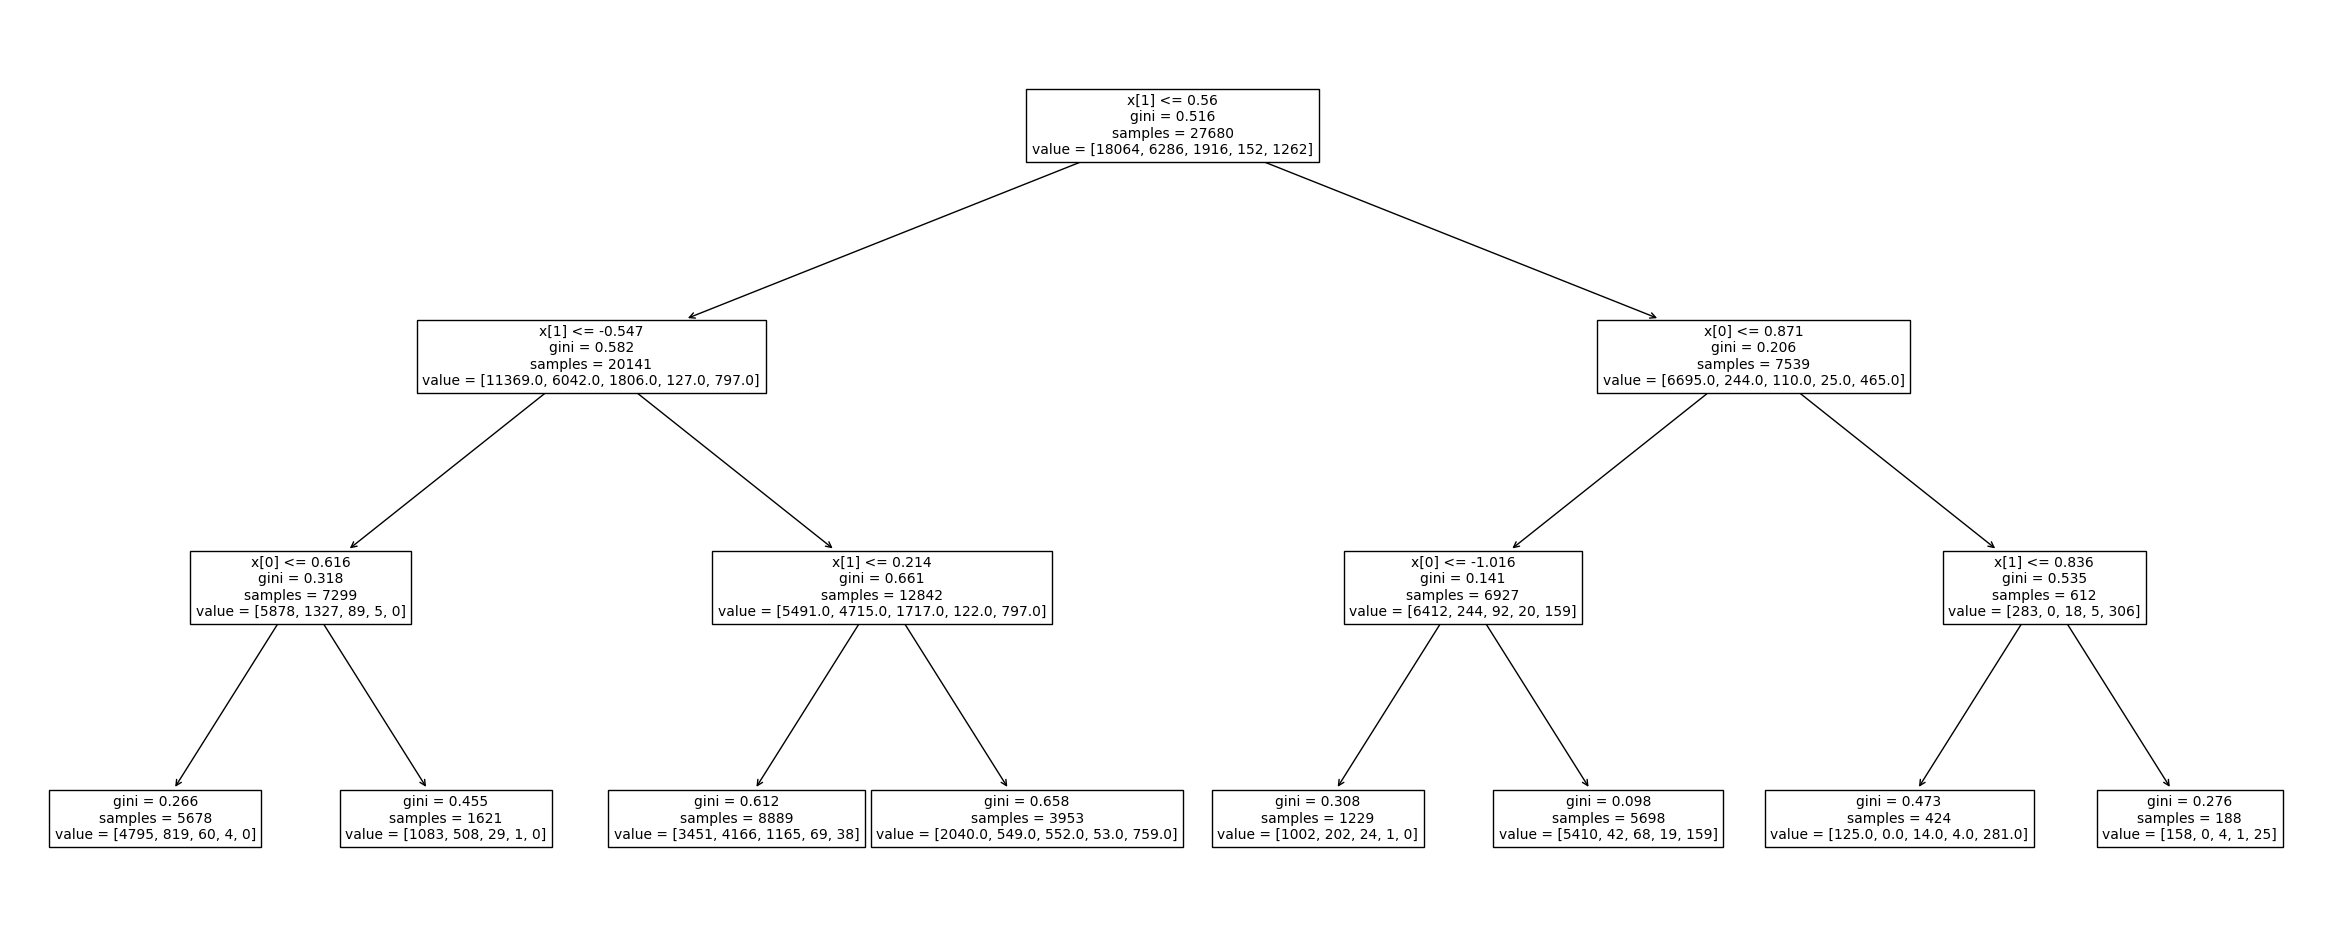

In [12]:
#Fit model
# index of 0 is launch_speed and 1 is launch_angle
decision_tree = DecisionTreeClassifier(min_samples_leaf=100, max_depth=3)
decision_tree.fit(X_train, Y_train)

#Show Tree
plt.figure(figsize = (30,12))
tree.plot_tree(decision_tree, fontsize = 10)
plt.show()

The below code goes over an example.

__Example__: If launch speed = 1 and launch angle = 0.7 (both in scaler form). Let's convert this point from scaler form to original form and this can be done with the scaler.inverse_transform function. So the point (1,0.7) corresponds to (103.0025 mph, 24.545 degrees). With this launch speed and angle, the probability it's an out is 32.55%, single 0.2604%, double 3.125%, triple 0.78125%, and home run 63.28%. So, this data point is most likely a home run or an out. 

In [13]:
test_df = pd.DataFrame({"launch_speed": [1], "launch_angle": [0.7]})
test_df

,launch_speed,launch_angle
0,1,0.7


In [14]:
decision_tree.predict_proba(test_df)

C:\Users\AGaev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


array([[0.29481132, 0.        , 0.03301887, 0.00943396, 0.66273585]])

In [15]:
original_point = scaler.inverse_transform(test_df)
original_point

array([[103.02178756,  34.56148602]])

In [16]:
test_df = pd.DataFrame({"launch_speed": [130], "launch_angle": [30]})
test_df

,launch_speed,launch_angle
0,130,30


In [17]:
scaled_point = scaler.transform(test_df)
scaled_point

array([[2.85782112, 0.54227987]])

In [18]:
decision_tree.predict_proba(scaled_point)

array([[0.51606375, 0.13888186, 0.13964078, 0.01340754, 0.19200607]])

In [ ]:
#100 mph is about .79 standard deviations vs average. 20 degrees is about .19 standard deviations vs average. 

In [ ]:
preds_test = decision_tree.predict_proba(X_test)
preds_test

## Calibration Curves for Each Event

In [20]:
#Calibration Curve for Each Event
def plot_calibration_curve(y_test, target_class, preds):
    """ This function ingests a target variable
    and predicted probabilities to generate
    a calibration cure

    @param y_test: This list contains the multiclass target
      for our hit type model
    @param target_class: Integer corresponding to one target
       in the y_test list
    @param preds: Numpy array of predicted probabilities for
       each target class in y_test
    
    Returns:
    
       -fig: Matplotlib object calibration curve
    """
    #Convert multiclass target to binary based on target class
    binary_target = [1 if y==target_class else 0 for y in y_test]
    
    # Initialize visualizaton
    fig = plt.figure(1, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)

    fraction_of_positives, mean_predicted_value = \
    calibration_curve(binary_target, preds [:,target_class], n_bins=10)
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-")
    ax1.set_xlabel("Predicted Frequency")
    ax1.set_ylabel("Observed Frequency")
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    plt.close ()
    
    return fig

In [21]:
fig_list = []
for target in range(0,5):
    fig = plot_calibration_curve(y_test = Y_test,target_class = target,preds = preds_test)
    fig_list.append(fig)

## Calibration Curve for an Out

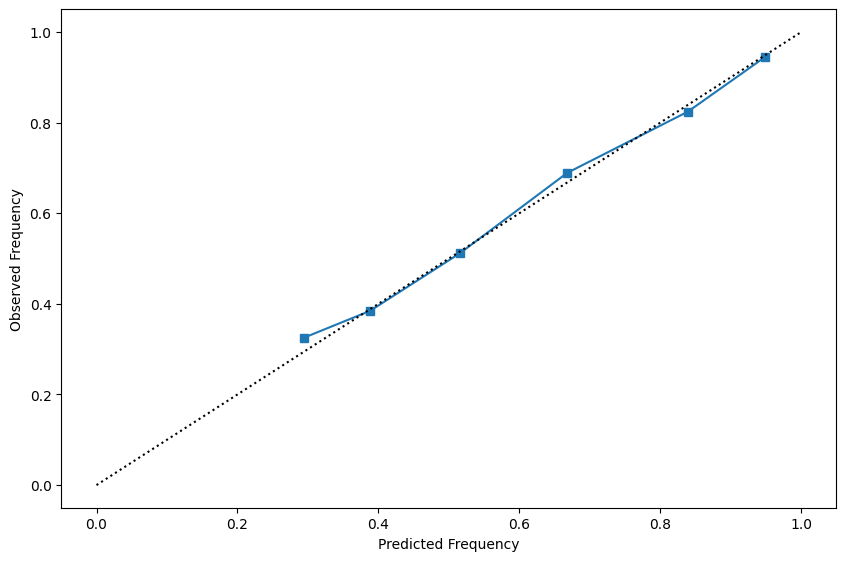

In [22]:
fig_list[0]

## Calibration Curve for a Single

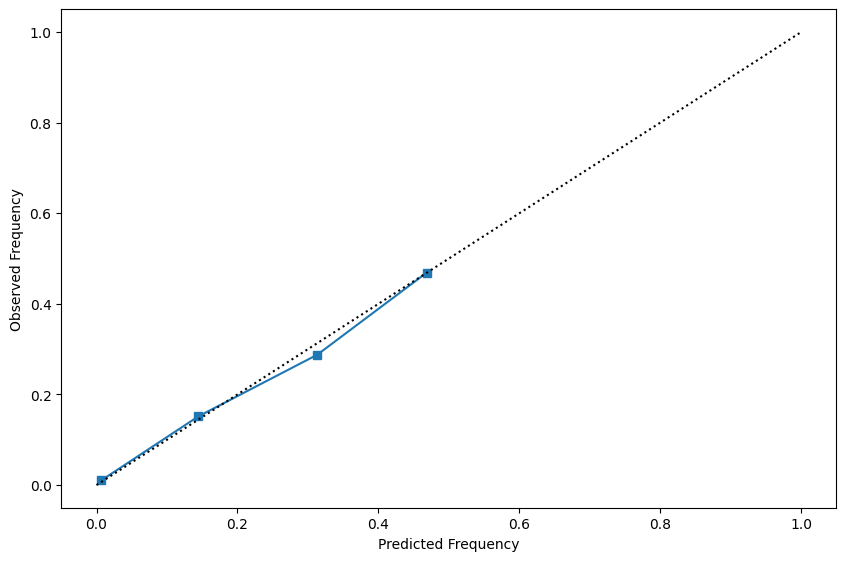

In [23]:
fig_list[1]

## Calibration Curve for a Double

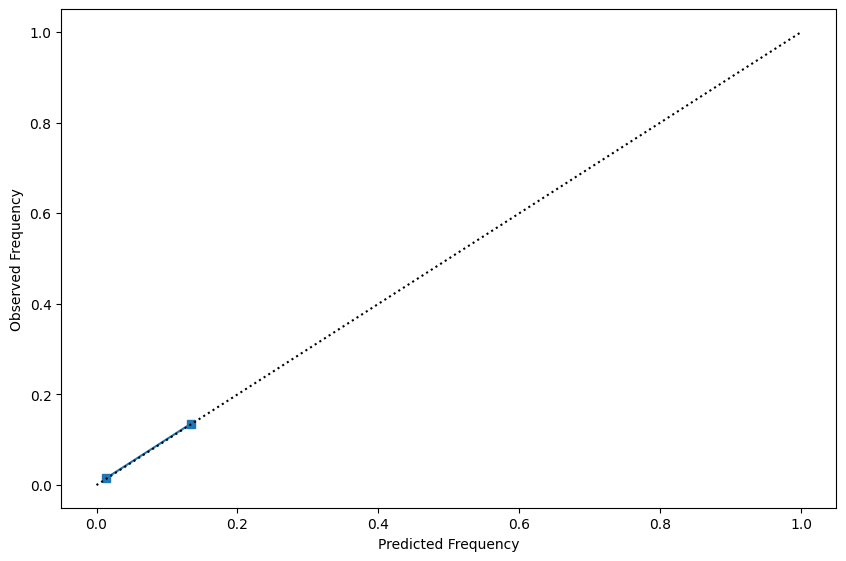

In [24]:
fig_list[2]

## Calibration Curve for a Triple

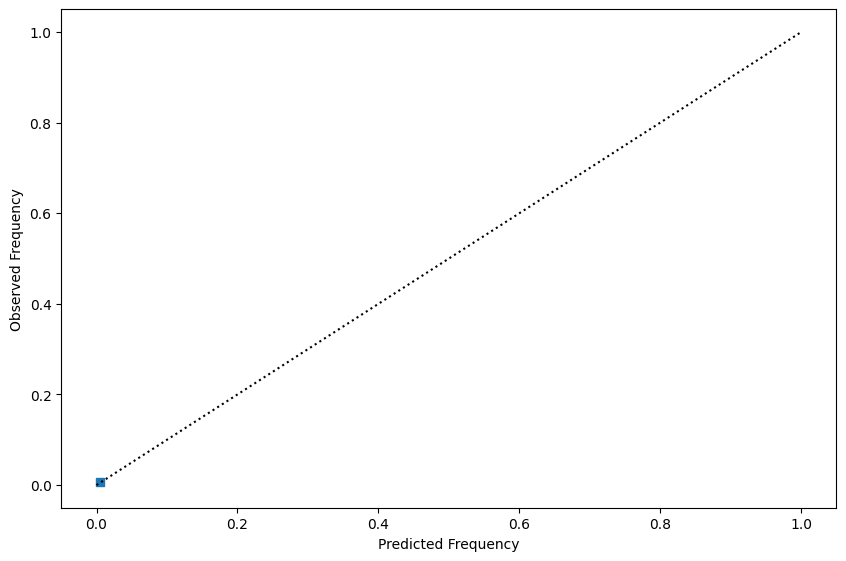

In [25]:
fig_list[3]

## Calibration Curve for a Home Run

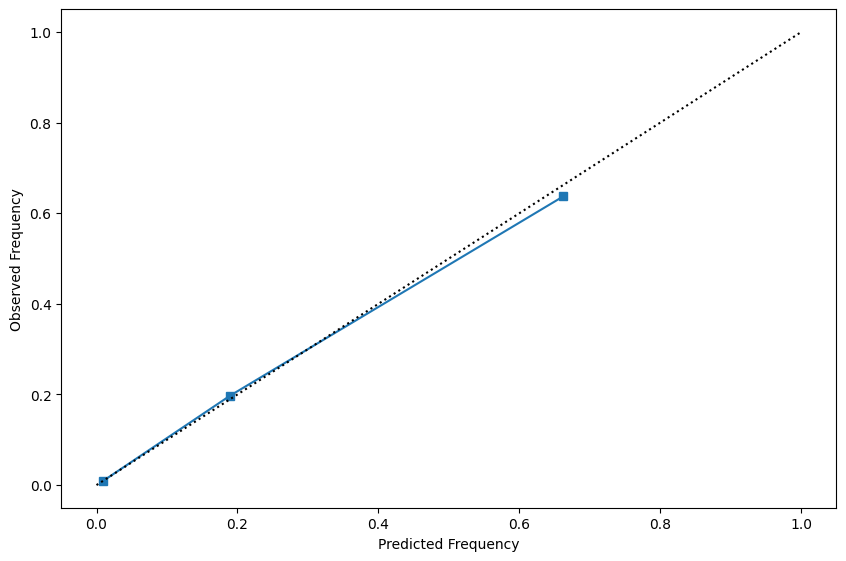

In [26]:
fig_list[4]

## Random Forest

A Random Forest is a model that is composed of multiple decision trees. 

In [27]:
rf_classifier = RandomForestClassifier(n_estimators=250, min_samples_leaf=100, max_depth=5)
rf_classifier.fit(X_train, Y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=100, n_estimators=250)

In [28]:
# feature that minimizes the gini index. When splitting, launch angles makes up roughly 2/3 of importance when minimizing the gini index
rf_classifier.feature_importances_

array([0.31109489, 0.68890511])

In [30]:
rf_classifier.predict_proba(rf_test_df)

C:\Users\AGaev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


array([[0.39048922, 0.01808349, 0.0984696 , 0.01452072, 0.47843698]])

In [29]:
rf_test_df = pd.DataFrame({"kick_distance": [1], "launch": [0.7]})  
rf_test_df

,launch_speed,launch_angle
0,1,0.7


In [31]:
rf_preds_test = rf_classifier.predict_proba(X_test)
rf_preds_test

array([[9.56806696e-01, 1.66254707e-02, 1.38579376e-02, 1.23616606e-03,
        1.14737298e-02],
       [8.05959125e-01, 1.69771512e-01, 2.24617198e-02, 1.38519181e-03,
        4.22451945e-04],
       [6.12976345e-01, 3.33772963e-01, 4.96991696e-02, 3.01956673e-03,
        5.31956451e-04],
       ...,
       [9.63457101e-01, 2.08359350e-02, 1.09310373e-02, 8.51737636e-04,
        3.92418924e-03],
       [4.19210566e-01, 4.67662660e-01, 1.02310910e-01, 6.59841334e-03,
        4.21745076e-03],
       [9.79779599e-01, 1.32626958e-02, 5.74399797e-03, 4.87033134e-04,
        7.26673769e-04]])

## Calibration Curves for Each Event

In [32]:
fig_list = []
for target in range(0,5):
    fig = plot_calibration_curve(y_test = Y_test,target_class = target,preds = rf_preds_test)
    fig_list.append(fig)

## Calibration Curve for an Out

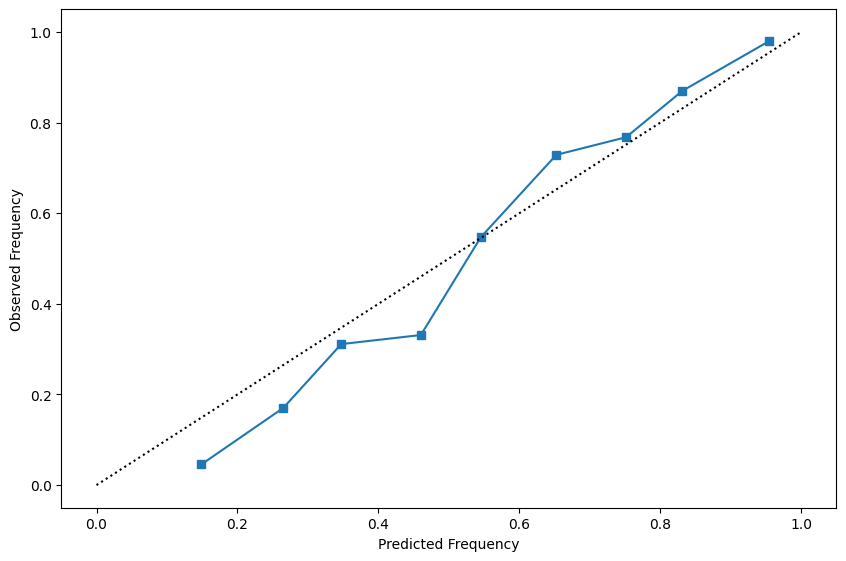

In [33]:
fig_list[0]
# try increasing max depth or increasing the number of trees in the forest


## Calibration Curve for a Single

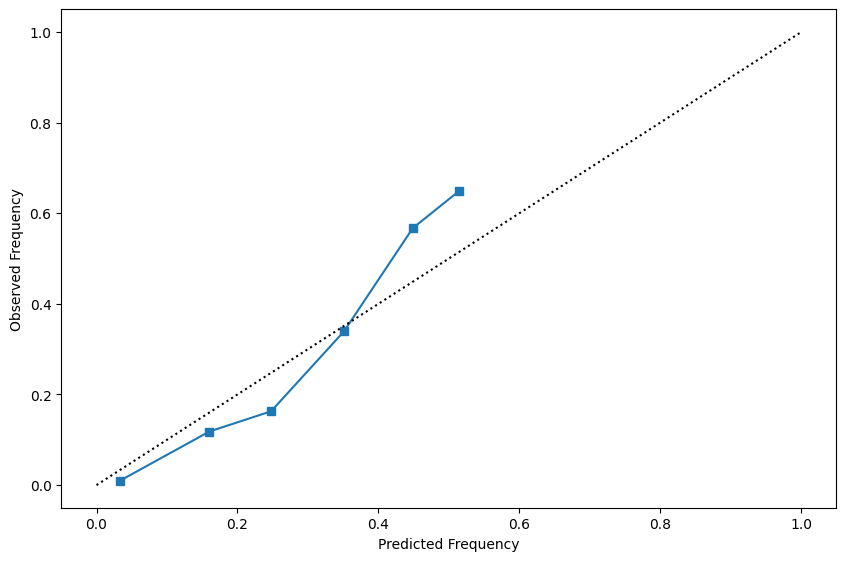

In [34]:
fig_list[1]

## Calibration Curve for a Double

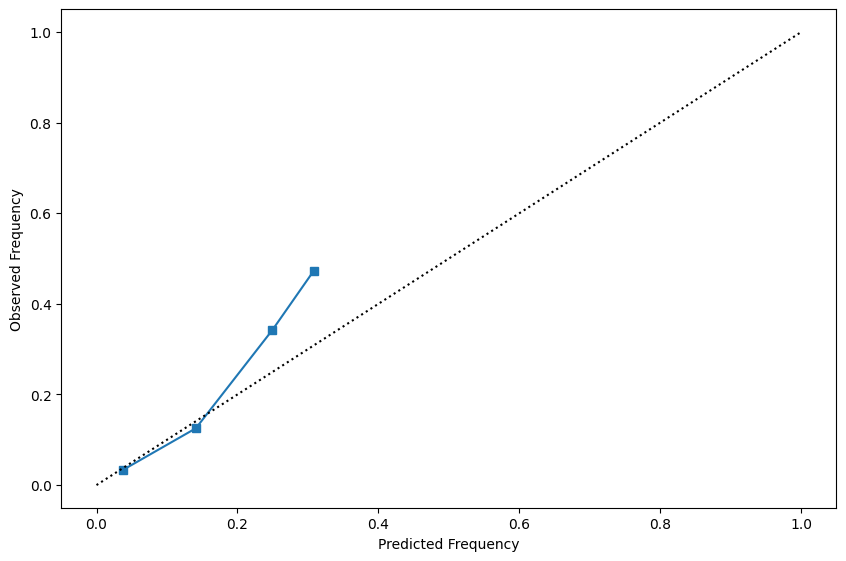

In [35]:
fig_list[2]

## Calibration Curve for a Triple

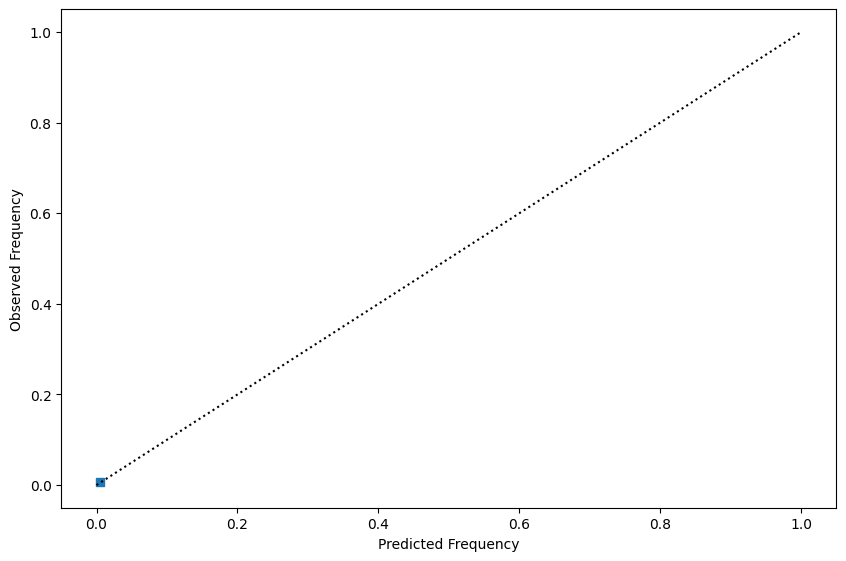

In [36]:
fig_list[3]

## Calibration Curve for a Home Run

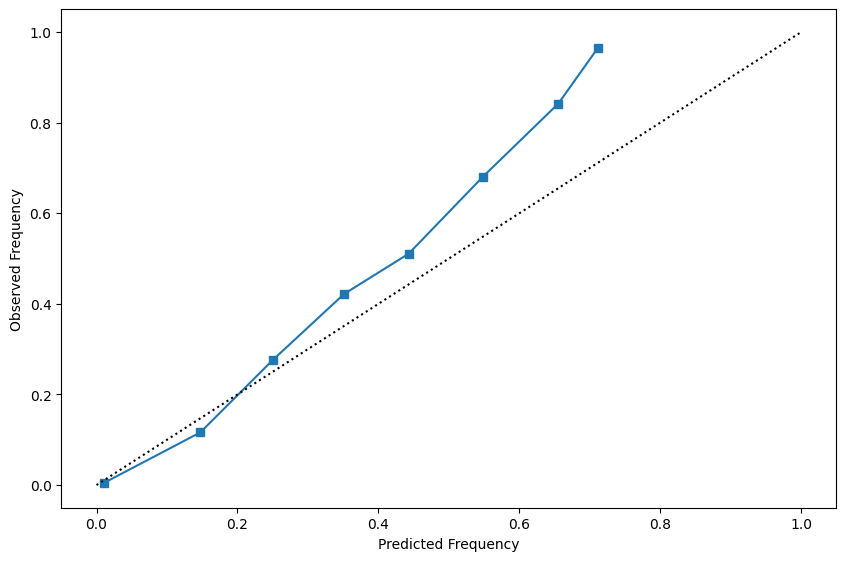

In [37]:
fig_list[4]

In [ ]:
# continue the evaluation of the models
# update the read me on github to give an overview of the project. Advertisment for your work (goal)

## Data Exploration

In [42]:
#Shows the probablility of each event for the given exit velocity and launch angle. A 1 indicates if the event occurred. 
RF_test_df = pd.DataFrame(X_test,columns= features)
for target in range(0,5):
    RF_test_df["target_" + str(target)] = [1 if y==target else 0 for y in Y_test]
    RF_test_df["pred_" + str(target)] = rf_preds_test[:, target]
RF_test_df

,launch_speed,launch_angle,target_0,pred_0,target_1,pred_1,target_2,pred_2,target_3,pred_3,target_4,pred_4
0,0.502681,0.991774,1,0.956807,0,0.016625,0,0.013858,0,0.001236,0,0.011474
1,0.302976,-1.117391,0,0.805959,1,0.169772,0,0.022462,0,0.001385,0,0.000422
2,-0.117093,-0.425862,0,0.612976,0,0.333773,1,0.049699,0,0.003020,0,0.000532
3,0.599090,-0.737050,1,0.700080,0,0.256624,0,0.038841,0,0.002727,0,0.001729
4,0.743704,0.611433,1,0.679439,0,0.034824,0,0.083320,0,0.015104,0,0.187313
...,...,...,...,...,...,...,...,...,...,...,...,...
83036,-0.874595,2.063645,1,0.963934,0,0.027689,0,0.007781,0,0.000256,0,0.000341
83037,1.136227,0.058209,1,0.326752,0,0.365796,0,0.257379,0,0.017963,0,0.032111
83038,0.296089,0.991774,1,0.963457,0,0.020836,0,0.010931,0,0.000852,0,0.003924
83039,0.599090,-0.149250,0,0.419211,1,0.467663,0,0.102311,0,0.006598,0,0.004217
